# 1 Predicting Gender of Brazilian Names Using Deep Learning in Data Lattes

## 1.1 Necessary libraries

In [1]:
import numpy as np
import pandas as pd                       
from joblib import dump, load
from tensorflow import keras
from unidecode import unidecode
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Bidirectional, Activation

## 1.2 Read the dataset

In [4]:
DataSEMISH = pd.read_csv(r"../data-from-SEMISH/dataSEMISH.csv")

In [5]:
DataSEMISH.head()

,Ano,Autor,Primeiro Nome,Titulos
0,2021,Jean Moraes,Jean,Implementação de um cluster Kubernetes com a p...
1,2021,Elen Lobato,Elen,Implementação de um cluster Kubernetes com a p...
2,2021,Denis Rosário,Denis,Implementação de um cluster Kubernetes com a p...
3,2021,Ubiratan Bezerra,Ubiratan,Implementação de um cluster Kubernetes com a p...
4,2021,Eduardo Cerqueira,Eduardo,Implementação de um cluster Kubernetes com a p...


In [7]:
print("Names : " + str(len(DataSEMISH["Primeiro Nome"])))

Names : 334


### 1.2.1 Preparing the data

In [28]:
data = DataSEMISH["Primeiro Nome"].apply(unidecode).apply(str.lower).apply(lambda x: x.replace("."," "))

## 1.3 Encoding Words

In [29]:
#word encoding
maxlen = 20                                               # max lenght of a name

'''Define a vocabulary which corresponds to all the unique letters encountered'''
vocab = set(' '.join([str(i) for i in data]))            # creating a vocab
vocab.add('END')
len_vocab = len(vocab)

char_index = dict((c, i) for i, c in enumerate(vocab))    # creating a dictionary
''' The dictionary maps each letter of vocabulary to a number '''

# Builds an empty line with a 1 at the index of character
def set_flag(i):
    aux = np.zeros(len_vocab);
    aux[i] = 1
    return list(aux)

# Truncate names and create the matrix
def prepare_encod_names(X):
    vec_names = []
    trunc_name = [str(i)[0:maxlen] for i in X]  # consider only the first 20 characters
    for i in trunc_name:
        tmp = [set_flag(char_index[j]) for j in str(i)]
        for k in range(0,maxlen - len(str(i))):
            tmp.append(set_flag(char_index["END"]))
        vec_names.append(tmp)
    return vec_names

'''This is called one-hot-encoder and is based on the following papers: 
https://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names
https://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...
 '''

'This is called one-hot-encoder and is based on the following papers: \nhttps://arxiv.org/abs/1707.07129 : Predicting the gender of Indonesian names\nhttps://ieeexplore.ieee.org/document/8560790 : Advance Gender Prediction Tool...\n '

In [30]:
x = prepare_encod_names(data)

## 1.4 BiLSTM Model

In [31]:
bilstm = keras.Sequential()
bilstm.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2), 
                            backward_layer=LSTM(128, return_sequences=False, go_backwards=True, dropout=0.2, recurrent_dropout=0.2),
                            input_shape=(maxlen,len_vocab)))
bilstm.add(Dense(1, activity_regularizer=l2(0.002)))
bilstm.add(Activation('sigmoid'))

In [32]:
bilstm.load_weights(filepath=r"../machine-learning-models/deep-learning-models/BiLSTM/Model/BiLSTM.hdf5")

## 1.5 Predict Gender

In [33]:
resu=(bilstm.predict(x) > 0.5).astype("int32")

#### 1.5.1.1 Analysis of results

In [34]:
DataSEMISH["BiLSTM"] = resu
DataSEMISH.sort_values("Ano", inplace=True)
DataSEMISH

,Ano,Autor,Primeiro Nome,Titulos,BiLSTM
333,2018,Leonardo Cunha de Miranda,Leonardo,Sustentabilidade de Foto-memórias na Era Digit...,0
331,2018,João C. P. da Silva,João,Extração de dados de fontes textuais: uma abor...,1
330,2018,Maria Luiza Machado Campos,Maria,Extração de dados de fontes textuais: uma abor...,1
328,2018,Priscila T. M. Saito,Priscila,SoyRetrieval - Técnicas de Aprendizado e Recup...,1
327,2018,Pedro H. Bugatti,Pedro,SoyRetrieval - Técnicas de Aprendizado e Recup...,0
...,...,...,...,...,...
13,2021,Aldebaro Klautau,Aldebaro,Middleware implementation for RYU SDN Controll...,0
14,2021,João Paulo K. S. Nunes,João,State of the Art on Microservices Autoscaling:...,1
15,2021,Thiago Bianchi,Thiago,State of the Art on Microservices Autoscaling:...,1
8,2021,Adriano Fiorese,Adriano,Uso de Aprendizado de Máquina Automatizado par...,0


In [35]:
data = dict()
F = 0
M = 0
ant = 2018
for ano, classi in zip(DataSEMISH["Ano"], DataSEMISH["BiLSTM"]):
    if ant != ano and ant != 0:
        data[ant] = [F, M]
        F, M = 0, 0
        ant = ano
    if classi == 1:
        F += 1
    if classi == 0:
        M += 1
data[ant] = [F, M]
print(data)

{2018: [26, 15], 2019: [39, 26], 2020: [67, 26], 2021: [99, 36]}


In [36]:
dftmp = pd.DataFrame()
dftmp["Ano"] = [x for x in data]
dftmp["F"] = [data[x][0] for x in data]
dftmp["M"] = [data[x][1] for x in data]
dftmp.set_index("Ano", inplace=True)

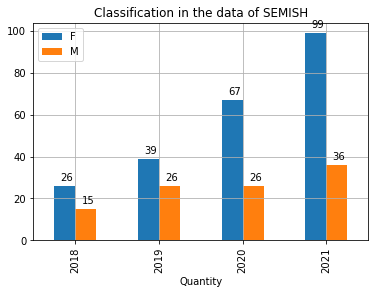

In [37]:
ax = dftmp.plot(kind="bar")
plt.title("Classification in the data of SEMISH")
plt.grid('True')
plt.xlabel('Quantity')
x_offset = -0.05
y_offset = 2.5
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}".format(b.y1 + b.y0)        
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

<AxesSubplot:title={'center':'Classificação com BiLSTM'}, xlabel='Ano'>

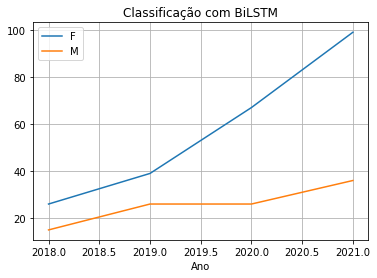

In [39]:
dftmp.plot.line(grid=True, title="Classificação com BiLSTM")